In [47]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [48]:
df = pd.read_excel("C:/Users/gvrk1/Downloads/Merged_Dropout_Data.xlsx")

In [49]:
df.head

<bound method NDFrame.head of      S.NO           State           Level Gender  Dropout Rate Academic year
0       1           India         Primary   Boys           0.8     2020-2021
1       2         Haryana         Primary  Girls           2.1     2020-2021
2       3         Haryana         Primary   Boys           2.2     2020-2021
3       4        Nagaland         Primary   Boys           6.6     2020-2021
4       5        Nagaland         Primary  Girls           5.2     2020-2021
..    ...             ...             ...    ...           ...           ...
661   218         Haryana  Upper Primary   Girls           3.7     2023-2024
662   219  Madhya Pradesh  Upper Primary   Girls           6.5     2023-2024
663   220    Chhattisgarh  Upper Primary   Girls           4.3     2023-2024
664   221      Chandigarh  Upper Primary   Girls           0.0     2023-2024
665   222    Chhattisgarh      Secondary    Boys          20.2     2023-2024

[666 rows x 6 columns]>

In [50]:
df.tail

<bound method NDFrame.tail of      S.NO           State           Level Gender  Dropout Rate Academic year
0       1           India         Primary   Boys           0.8     2020-2021
1       2         Haryana         Primary  Girls           2.1     2020-2021
2       3         Haryana         Primary   Boys           2.2     2020-2021
3       4        Nagaland         Primary   Boys           6.6     2020-2021
4       5        Nagaland         Primary  Girls           5.2     2020-2021
..    ...             ...             ...    ...           ...           ...
661   218         Haryana  Upper Primary   Girls           3.7     2023-2024
662   219  Madhya Pradesh  Upper Primary   Girls           6.5     2023-2024
663   220    Chhattisgarh  Upper Primary   Girls           4.3     2023-2024
664   221      Chandigarh  Upper Primary   Girls           0.0     2023-2024
665   222    Chhattisgarh      Secondary    Boys          20.2     2023-2024

[666 rows x 6 columns]>

In [51]:
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

def parse_year(x):
    if pd.isna(x): return np.nan
    m = re.search(r'(\d{4})', str(x))
    return int(m.group(1)) if m else np.nan

df['year'] = df['academic_year'].apply(parse_year)

In [52]:
df_model = df[['state','level','gender','dropout_rate','year']].dropna(subset=['state','level','gender','dropout_rate','year'])


In [53]:
df_model = df_model.sort_values(['state','level','gender','year'])
df_model['lag1_dropout_rate'] = df_model.groupby(['state','level','gender'])['dropout_rate'].shift(1)
df_model['lag2_dropout_rate'] = df_model.groupby(['state','level','gender'])['dropout_rate'].shift(2)
# fill missing lags sensibly
df_model['lag1_dropout_rate'] = df_model['lag1_dropout_rate'].fillna(
    df_model.groupby(['state','level','gender'])['dropout_rate']
           .transform(lambda x: x.expanding().mean().shift(1))
           .fillna(method='bfill')
)
df_model['lag2_dropout_rate'] = df_model['lag2_dropout_rate'].fillna(df_model['lag1_dropout_rate'])


C:\Users\gvrk1\AppData\Local\Temp\ipykernel_24016\3556418033.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


In [54]:
le_state = LabelEncoder(); df_model['state_enc'] = le_state.fit_transform(df_model['state'].astype(str))
le_gender = LabelEncoder(); df_model['gender_enc'] = le_gender.fit_transform(df_model['gender'].astype(str))
le_level = LabelEncoder(); df_model['level_enc'] = le_level.fit_transform(df_model['level'].astype(str))


In [55]:
features = ['year','state_enc','gender_enc','level_enc','lag1_dropout_rate','lag2_dropout_rate']
target = 'dropout_rate'

train_df = df_model[df_model['year'] <= 2023].dropna(subset=features+[target])
val_df   = df_model[df_model['year'] == 2023].dropna(subset=features+[target])

X_train, y_train = train_df[features], train_df[target]
X_val,   y_val   = val_df[features], val_df[target]


In [56]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {'n_estimators':[50,100], 'max_depth':[5,10,None]}
gscv = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
gscv.fit(X_train, y_train)
best_model = gscv.best_estimator_


In [57]:
y_pred_val = best_model.predict(X_val)
mae  = mean_absolute_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
r2   = r2_score(y_val, y_pred_val)
print(mae, rmse, r2)


2.495546256511408 3.6361500575104584 0.7143386368151244


C:\Users\gvrk1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [58]:
# Step 1: Get the last available year’s data for each State × Level × Gender
last_rows = (
    df_model
    .groupby(['state', 'level', 'gender'])
    .apply(lambda g: g.sort_values('year').iloc[-1])  # pick the latest year row
    .reset_index(drop=True)
)

# Step 2: Prepare a copy for prediction and set year = 2025
pred_df = last_rows.copy()
pred_df['year'] = 2025

# Step 3: Shift lag features for prediction
#  lag2 for 2025 comes from lag1 of last available year
pred_df['lag2_dropout_rate'] = pred_df['lag1_dropout_rate']
#  lag1 for 2025 comes from actual dropout rate of last available year
pred_df['lag1_dropout_rate'] = pred_df['dropout_rate']

# Step 4: Fill any missing lag values with mean from training data
pred_df['lag1_dropout_rate'] = pred_df['lag1_dropout_rate'].fillna(train_df['lag1_dropout_rate'].mean())
pred_df['lag2_dropout_rate'] = pred_df['lag2_dropout_rate'].fillna(train_df['lag2_dropout_rate'].mean())

# Step 5: Encode categorical columns (State, Gender, Level) using fitted encoders
pred_df['state_enc'] = le_state.transform(pred_df['state'].astype(str))
pred_df['gender_enc'] = le_gender.transform(pred_df['gender'].astype(str))
pred_df['level_enc'] = le_level.transform(pred_df['level'].astype(str))

# Step 6: Make predictions for 2025
pred_df['predicted_dropout_rate_2025'] = best_model.predict(pred_df[features])

# Step 7: Save the results to CSV
pred_df.to_csv("predicted_dropout_rate_2025.csv", index=False)

print("✅ Predictions saved to predicted_dropout_rate_2025.csv")


✅ Predictions saved to predicted_dropout_rate_2025.csv


C:\Users\gvrk1\AppData\Local\Temp\ipykernel_24016\1522553401.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('year').iloc[-1])  # pick the latest year row


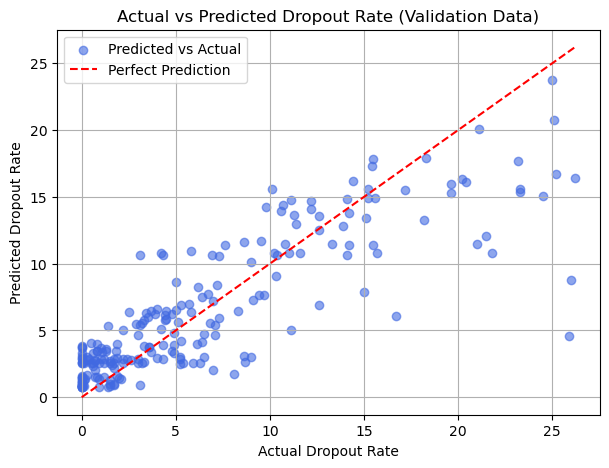

In [59]:
# Get actual and predicted values from validation set
y_val = y_val  # your actual dropout rates from validation set
y_val_pred = best_model.predict(X_val)  # predicted dropout rates

import matplotlib.pyplot as plt

# ---- Plot Actual vs Predicted ----
plt.figure(figsize=(7, 5))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='royalblue', label='Predicted vs Actual')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Dropout Rate")
plt.ylabel("Predicted Dropout Rate")
plt.title("Actual vs Predicted Dropout Rate (Validation Data)")
plt.legend()
plt.grid(True)
plt.show()


In [60]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [61]:
df = pd.read_excel("C:/Users/gvrk1/Downloads/Merged_Dropout_Data.xlsx")

In [62]:
# Step 3 (updated): Features & target
X = df.drop(columns=["Dropout Rate"])
y = df["Dropout Rate"]

# Convert categorical (text) columns to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)


In [63]:
# Step 4: Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [64]:
# Step 5: Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [65]:
# Step 6: Predict on validation set
y_val_pred = model.predict(X_val)

In [66]:
# Step 7: Calculate metrics
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation R²: {r2:.3f}")

Validation MAE: 2.571
Validation RMSE: 3.850
Validation R²: 0.675


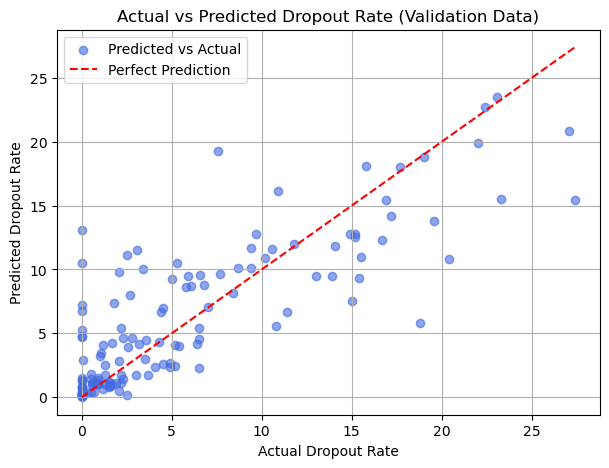

In [67]:
# Step 8: Plot Actual vs Predicted
plt.figure(figsize=(7, 5))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='royalblue', label='Predicted vs Actual')
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Dropout Rate")
plt.ylabel("Predicted Dropout Rate")
plt.title("Actual vs Predicted Dropout Rate (Validation Data)")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [68]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation R²: {r2:.3f}")


Validation MAE: 2.622
Validation RMSE: 3.800
Validation R²: 0.684


C:\Users\gvrk1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [69]:
from sklearn.model_selection import RandomizedSearchCV


In [70]:
xgb = XGBRegressor(random_state=42)

In [71]:
# Step 7: Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3]
}

In [72]:
# Step 8: Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [73]:
# Step 9: Best model
best_model = random_search.best_estimator_

In [74]:
# Step 10: Validation
y_val_pred = best_model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
r2 = r2_score(y_val, y_val_pred)

print("Best Parameters:", random_search.best_params_)
print(f"Validation MAE: {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation R²: {r2:.3f}")


Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Validation MAE: 2.780
Validation RMSE: 3.880
Validation R²: 0.670


C:\Users\gvrk1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [75]:
# Step 1: Define wider param grid
param_grid = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3, 0.5]
}

In [76]:
# Step 2: Model
xgb = XGBRegressor(random_state=42, objective="reg:squarederror")

In [77]:
# Step 3: Randomized Search with more iterations
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=80,           # Increased from 30
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [78]:
# Step 4: Fit
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.6, 0.8,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6, 8],
                                        'n_estimators': [200, 300, 500, 800],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [79]:
# Step 5: Best model evaluation
best_xgb = random_search.best_estimator_
y_pred_val = best_xgb.predict(X_val)

print("Best Parameters:", random_search.best_params_)
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("Validation R²:", r2_score(y_val, y_pred_val))

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}
Validation MAE: 2.572691308295549
Validation RMSE: 3.6669347860855113
Validation R²: 0.7053433752778193
